#Import statements

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
import cv2 
import numpy as np
import matplotlib
import skimage
from matplotlib import pyplot as plt


Using TensorFlow backend.


# Custom functions

In [0]:
def image_pre(file,factor):
  img=cv2.imread(file)
  h,w,_ =img.shape
  n_h=int(h/factor)
  n_w=int(w/factor)
  img=cv2.resize(img,(n_h,n_w),interpolation = cv2.INTER_LINEAR)
  img=cv2.resize(img,(w,h),interpolation=cv2.INTER_LINEAR)
  cv2.imwrite('processed_img.jpg',img)


    

def model():
    custom_model = Sequential()
    custom_model.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    custom_model.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    custom_model.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    adam = Adam(lr=0.0003)
    custom_model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    return custom_model

def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def trim(image, border):
    img = image[border: -border, border: -border]
    return img

def predict(image_path):
    custom_model = model()
    custom_model.load_weights('/content/custom_weights.h5')
    proc_img = cv2.imread(image_path)
    ref = cv2.imread('/content/GOKU.bmp')    
    ref = modcrop(ref, 3)
    proc_img = modcrop(proc_img, 3)
    temp = cv2.cvtColor(proc_img, cv2.COLOR_BGR2YCrCb)
    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    super = custom_model.predict(Y, batch_size=1)
    super *= 255
    super[super[:] > 255] = 255
    super[super[:] < 0] = 0
    super = super.astype(np.uint8)
    temp = trim(temp, 6)
    temp[:, :, 0] = super[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    ref = trim(ref.astype(np.uint8), 6)
    proc_img = trim(proc_img.astype(np.uint8), 6)
    return ref, proc_img, output


# Main

In [0]:
file='/content/GOKU.bmp'
image_pre(file,2)

target = cv2.imread('/content/processed_img.jpg')
ref = cv2.imread('/content/GOKU.bmp')

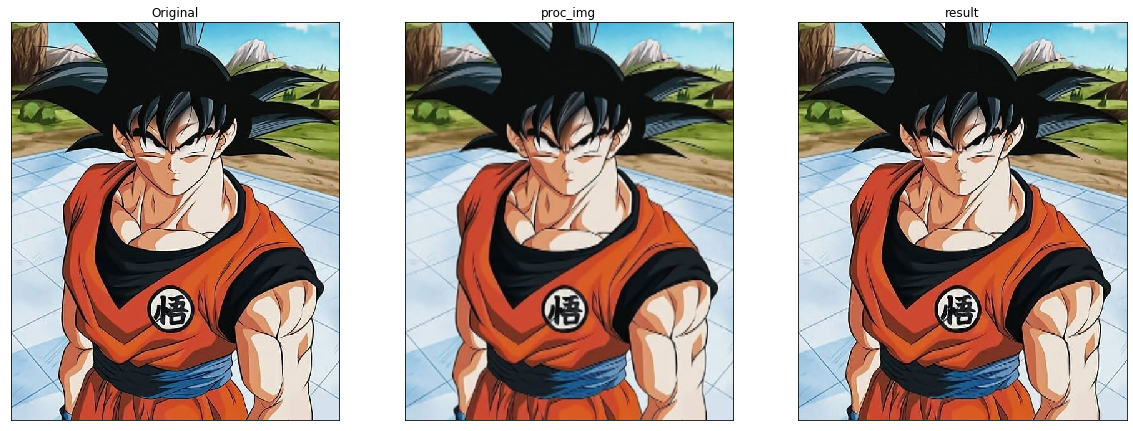

In [4]:
ref, proc_img, output = predict('/content/processed_img.jpg')

fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(proc_img, cv2.COLOR_BGR2RGB))
axs[1].set_title('proc_img')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('result')
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])